In [1]:
# Imports Girder Client, HistomicsTK utils, Python os, sys functions
import os, sys, json, glob
import numpy as np
import girder_client
import histomicstk.utils as htk_utils
from cStringIO import StringIO
import io, random
import logging
from os.path import join as opj
import matplotlib.pyplot as plt
from PIL import Image

cohort = "gbm"

INFO:girder:Created LRU Cache for 'tilesource' with 104 maximum size
INFO:root:Notice: Could not import MapnikTileSource


In [2]:
logging.getLogger("requests").setLevel(logging.WARNING)
#gc = girder_client.GirderClient(apiUrl="http://candygram.neurology.emory.edu:8080/api/v1")
gc = girder_client.GirderClient(apiUrl="http://digitalslidearchive.emory.edu:8080/api/v1")

## Connect to girder and get the cohort ID's for all the TCGA collections
tcgaCohorts = gc.get('/tcga/cohort')  ## This gets me the folderID for all the TCGA cohorts
cohortInfo = dict([(x['name'],x['_id']) for x in tcgaCohorts['data']])

slidesInCohort = gc.get('/tcga/cohort/%s/images?limit=%d' % (cohortInfo[cohort],200))
## PROBABLY should write a generator to grab all the slides instead of just specifying some giant number

### For now I am going to filter out any non DX Cases
dxSlides = [x for x in slidesInCohort['data'] if '-DX' in x['name']]
print(len(dxSlides),"for the %s Cohort"%cohort)

for idx,sl in enumerate(dxSlides):
    lowResMag = 0.625
    lowResImg = gc.get('/item/%s/tiles/region?magnification=%s' % (sl['_id'], lowResMag),jsonResp=False)    
    lowResPILimage = Image.open(io.BytesIO(lowResImg.content))
    break
    
class LinePrinter():
    """
    Print things to stdout on one line dynamically
    """
    def __init__(self,data):
        sys.stdout.write("\r\x1b[K"+data.__str__())
        sys.stdout.flush()

(64, 'for the gbm Cohort')


In [3]:
def grabTilesFromImage(imageData, outputDir, lowResMag=0.625, outputRes=20, tilesToOutput=200,debug=False):
    ### This receives a list of images from Girder and will generate tiles and place them in 
    ### Train and Test Directories-- it will split based on train_test_split and also
    ## Will run a low res segmentation step prior to trying to randomly grab tiles from the input stream
    ## outputDir should be something like /data/train/gbm or similar; I'll have the function calling this make sure those
    ## Dirs already exist

    ## Pull the image from girder and then use PIL to turn the raw bytes in an image object
    if debug:
        print("Analyzing %s; pulling base image at %s and outputing tiles at %s" % (imageData['name'],lowResMag,outputRes))
    lowResImg = gc.get('/item/%s/tiles/region?magnification=%s' % ( imageData['_id'], lowResMag),jsonResp=False)    
    lowResPILimage = Image.open(io.BytesIO(lowResImg.content))

    # Using HistomicsTK utils's simple mask function to mask out tissue areas from background in brightfield H&E images
    im_fgnd_mask_lres = htk_utils.simple_mask(np.asarray(lowResPILimage))

    # To extract masked coordinates from numpy array
    (YmaskPts,XmaskPts)  = np.nonzero(im_fgnd_mask_lres)
    maskCoords = zip(XmaskPts,YmaskPts) # To change into (x, y) form

    # To Create a bounding box of masked image
    scaleFactor = 32 # this is the high magnification (20x) / low res (0.625)
    left   = int(min(XmaskPts) * scaleFactor)
    top    = int(min(YmaskPts) * scaleFactor)
    right  = int(max(XmaskPts) * scaleFactor)
    bottom = int(max(YmaskPts) * scaleFactor)
    left, right, top, bottom

    # To generate tile corners from the bounding box
    corners = []
    for x in range(left, right, 256):
        for y in range(top, bottom, 256):
            corners.append([x,y])
        
    np.random.shuffle(corners)

    slideBaseName =  sl['name'].split(".")[0]

    regionWidth = regionHeight = 256
    outputRes = 20
    count = 0

    for c in corners:
        x_low = c[0] / scaleFactor
        y_low = c[1] / scaleFactor
        top = c[1]
        left = c[0]
        
        # Extracts tile for the specified corner region 
        curTile = gc.get('/item/%s/tiles/region?magnification=%s&top=%d&left=%d&regionWidth=%d&regionHeight=%d' 
            % ( imageData['_id'], outputRes, top, left,regionWidth,regionHeight),jsonResp=False)
        
        img = np.asarray(Image.open(io.BytesIO(curTile.content))) # Converts binary image to numpy array
        label = im_fgnd_mask_lres[y_low, x_low]
        
        if label:
            count += 1
            plt.imshow(img)
            #plt.show()
            tilename = outputDir + "/"+ slideBaseName + '_%dx_%d_%d_%dx%d.jpg' % (outputRes, top, left,regionWidth,regionHeight) 
            plt.savefig(tilename)
            
            if count > tilesToOutput:
                break                       

Analyzing TCGA-02-0001-01Z-00-DX2.b521a862-280c-4251-ab54-5636f20605d0.svs; pulling base image at 0.625 and outputing tiles at 20
Analyzing TCGA-02-0001-01Z-00-DX2.b521a862-280c-4251-ab54-5636f20605d0.svs; pulling base image at 0.625 and outputing tiles at 20
Analyzing TCGA-02-0001-01Z-00-DX3.2836ce55-491f-4d86-99b1-668946927af8.svs; pulling base image at 0.625 and outputing tiles at 20
Analyzing TCGA-02-0001-01Z-00-DX3.2836ce55-491f-4d86-99b1-668946927af8.svs; pulling base image at 0.625 and outputing tiles at 20
Analyzing TCGA-02-0003-01Z-00-DX2.c7652d8d-d78f-49ae-8259-bb2bdb5d50fb.svs; pulling base image at 0.625 and outputing tiles at 20
Analyzing TCGA-02-0003-01Z-00-DX2.c7652d8d-d78f-49ae-8259-bb2bdb5d50fb.svs; pulling base image at 0.625 and outputing tiles at 20
Analyzing TCGA-02-0003-01Z-00-DX3.995C2924-E298-4517-82A4-15806766CE31.svs; pulling base image at 0.625 and outputing tiles at 20
Analyzing TCGA-02-0003-01Z-00-DX3.995C2924-E298-4517-82A4-15806766CE31.svs; pulling base i

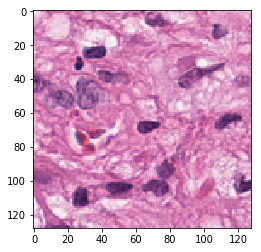

In [4]:
train  = 0.8
totalSlides = len(dxSlides)
## Output Testing & Training Images for Cohort

for idx,sl in enumerate(dxSlides):
## I am assuming 80% i.e. 16/20 = 0.8...
    if( (idx % 20)  <  16 ):
        opd = "/data/train/%s" % cohort
    else:
        opd = "/data/test/%s" % cohort

    if not os.path.isdir(opd):
        os.makedirs(opd)
        print("Outputing test set now!!")

    slideBaseName = sl['name'].split(".")[0]
    tilesFound = glob.glob(opd+"/%s*png" %  (slideBaseName))
    
    tilesWanted = 5
    tilesToGenerate = tilesWanted - len(tilesFound)
    
    if (tilesToGenerate) > 0:
        grabTilesFromImage( sl, opd, lowResMag=0.625, outputRes=20, tilesToOutput=tilesWanted,debug=True)
        #grabTilesFromImage( sl, opd, lowResMag=0.625, outputRes=20, tilesToOutput=tilesToGenerate,debug=True)
    else:
        stats = "Processed %d images" % idx
        LinePrinter(stats)

In [5]:
totalSlides

64

In [ ]:
for idx,sl in enumerate(dxSlides):
    lowResMag = 0.625
    lowResImg = gc.get('/item/%s/tiles/region?magnification=%s' % (sl['_id'], lowResMag),jsonResp=False)    
    lowResPILimage = Image.open(io.BytesIO(lowResImg.content))
    break
sl['_id']

In [ ]:
sl['name']

In [ ]:
im_fgnd_mask_lres = htk_utils.simple_mask(np.asarray(lowResPILimage))

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
plt.imshow(im_fgnd_mask_lres, cmap=plt.cm.gray)

In [ ]:
(YmaskPts,XmaskPts)  = np.nonzero(im_fgnd_mask_lres)
maskCoords = zip(XmaskPts,YmaskPts) # (x, y) form

scaleFactor = 32 # this is the high magnification (20x) / low res (0.625)
left   = int(min(XmaskPts) * scaleFactor)
top    = int(min(YmaskPts) * scaleFactor)
right  = int(max(XmaskPts) * scaleFactor)
bottom = int(max(YmaskPts) * scaleFactor)
left, right, top, bottom

corners = []
for x in range(left, right, 256):
    for y in range(top, bottom, 256):
        corners.append([x,y])
        
np.random.shuffle(corners)

slideBaseName =  sl['name'].split(".")[0]

regionWidth = regionHeight = 256
outputRes = 20
count = 0

for c in corners:
    x_low = c[0] / scaleFactor
    y_low = c[1] / scaleFactor
    top = c[1]
    left = c[0]
    
    
    
    curTile = gc.get('/item/%s/tiles/region?magnification=%s&top=%d&left=%d&regionWidth=%d&regionHeight=%d' 
        % ( sl['_id'], outputRes, top, left,regionWidth,regionHeight),jsonResp=False)
    img = np.asarray(Image.open(io.BytesIO(curTile.content)))
    label = im_fgnd_mask_lres[y_low, x_low]
    if label:
        count += 1
        print (c[0], c[1], x_low, y_low, top, left)
        plt.imshow(img)
        plt.show()
        

    if count > 10:
        break

In [ ]:
c[0], c[1]

In [ ]:
# outputRes = 20
# lowResMag = 0.625
scaleFactor = 20/0.625  ##scaleFactor = outPutRes/lowResMag
left   = int(min(XmaskPts) * scaleFactor)
top    = int(min(YmaskPts) * scaleFactor)
right  = int(max(XmaskPts) * scaleFactor)
bottom = int(max(YmaskPts) * scaleFactor)

corners = []

for x in range(left, right, 256):
    for y in range(top, bottom, 256):
        corners.append([x,y])
        
np.random.shuffle(corners)

slideBaseName =  sl['name'].split(".")[0]

tilename  = []
tilecount = 0

mask = im_fgnd_mask_lres

rScaleFactor = 0.625/20

test = np.zeros(mask.shape)

for idx, c in enumerate(corners):
    # get region, you have top left corner.
    regionWidth = regionHeight = 256
#     curTile = gc.get('/item/%s/tiles/region?magnification=%s&top=%d&left=%d&regionWidth=%d&regionHeight=%d' 
#                            % ( sl['_id'], outputRes, top, left,regionWidth,regionHeight),jsonResp=False)
#     img = np.asarray(Image.open(io.BytesIO(curTile.content)))
    
    x_low, y_low = int(c[0]*rScaleFactor), int(c[1]*rScaleFactor)
#         # check if middle pixel is 1 or 0 in mask
#         # if 1 save tile, count++
    test[y_low, x_low] = 1
#     print y_low, x_low
#     if mask[x_low, y_low]:   
#         print(True)
#     if centerPt == 1:
#         img = Image.open(io.BytesIO(curTile.content))
#         avg = np.average(img)

#         status = "Image %s of %s, imgavg:%s" % (idx, maxx,avg)

#         if avg > 150 and avg < 210:
#             tilename = slideBaseName + '_%dx_%d_%d_%dx%d.png' % (outputRes, top, left,regionWidth, regionHeight) 
#             img.save(opj(outputDir,tilename))
#             tilecount+=1

#         if tilecount > tilesToOutput or tilecount > maxx:
#             break 


In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(test, cmap=plt.cm.gray)

In [ ]:
lowResPILimage

In [ ]:
class LinePrinter():
    """
    Print things to stdout on one line dynamically
    """
    def __init__(self,data):
        sys.stdout.write("\r\x1b[K"+data.__str__())
        sys.stdout.flush()

In [ ]:
def grabTilesFromImage( imageData, outputDir, lowResMag=1.25, outputRes=20, tilesToOutput=200,debug=False):
    ### This receives a list of images from Girder and will generate tiles and place them in 
    ### Train and Test Directories-- it will split based on train_test_split and also
    ## Will run a low res segmentation step prior to trying to randomly grab tiles from the input stream
    ## outputDir should be something like /data/train/gbm or similar; I'll have the function calling this make sure those
    ## Dirs already exist

    ## Pull the image from girder and then use PIL to turn the raw bytes in an image object
    if debug:
        print("Analyzing %s; pulling base image at %s and outputing tiles at %s" % (imageData['name'],lowResMag,outputRes))
    lowResImg = gc.get('/item/%s/tiles/region?magnification=%s' % ( imageData['_id'], lowResMag),jsonResp=False)    
    lowResPILimage = Image.open(io.BytesIO(lowResImg.content))

    ## Pass the low res image to htk_simple_mask; but first convert to nparray for processing
    im_fgnd_mask_lres = htk_utils.simple_mask(np.asarray(lowResPILimage))

    ### NEXT STEP--- I need to grab every POINT in the MASK.. and then grab 100 Random Tiles...
    ## FIGuRE OUT THE INDEXES OF ALL POINTS IN THE MASK
    (YmaskPts,XmaskPts)  = np.nonzero(im_fgnd_mask_lres)  ## This returns a  Tuples of 2 arrays  X and Y coordinates of non zero points
    ## Zip Y and X into Coords
    maskCoords = zip(YmaskPts,XmaskPts)
    
    
    
    

    scaleFactor = outputRes/ lowResMag  ### Need to multiply the Y And X coords by this number to get the target coordinates
    maxx = len(maskCoords)
    random.shuffle(maskCoords)  ### shuffle the points and then chose however many pts I wnat to grab tiles for
    # To save the tiles into file
    slideBaseName =  imageData['name'].split(".")[0]

    tilename =[]
    tilecount=0
    for idx, c in enumerate(maskCoords):
        top = c[0]* scaleFactor ## These are scaled to the output res
        left = c[1]* scaleFactor 
        regionWidth = regionHeight = 256

        curTile = gc.get('/item/%s/tiles/region?magnification=%s&top=%d&left=%d&regionWidth=%d&regionHeight=%d' 
                           % ( imageData['_id'], outputRes, top, left,regionWidth,regionHeight),jsonResp=False)
        img = Image.open(io.BytesIO(curTile.content))
        avg = np.average(img)

        status = "Image %s of %s, imgavg:%s" % (idx, maxx,avg)
        if debug:
            LinePrinter(status)

        if avg > 150 and avg < 210:
            tilename = slideBaseName + '_%dx_%d_%d_%dx%d.png' % (outputRes, top, left,regionWidth, regionHeight) 
#            print(outputDir+tilename)
            img.save(opj(outputDir,tilename))
            tilecount+=1

        if tilecount > tilesToOutput or tilecount > maxx:
            break

In [ ]:
top = 30
bottom = 3000
left = 350
right = 7000

corners = []

for x in range(left, right, 256):
    for y in range(top, bottom, 256):
        corners.append([x,y])
l = len(corners)
np.random.shuffle(corners)